# correctionlib-gradients @ AGC Demo Day 30/11/2023

### Enrico Guiraud with help from Nick Smith and Lukas Heinrich

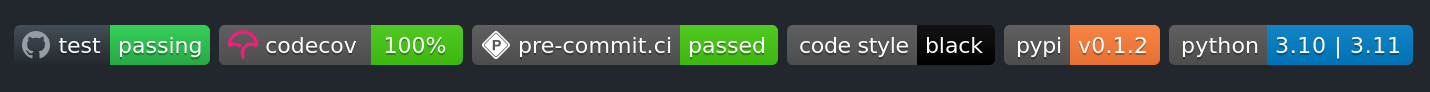

## What

A [JAX](https://jax.readthedocs.io)-friendly, autodifferentiable, Python-only implementation of a subset of [correctionlib](https://github.com/cms-nanoAOD/correctionlib) correction evaluations.

If you don't know what these terms mean, for the purposes of this presentation:
- automatic differentiation aka autodiff is a method to compute gradients of numerical functions: `f(x) -> df/dx(x)`
- [JAX](https://jax.readthedocs.io) is (among other things) a Python tool to make functions that operate on arrays autodifferentiable
- [correctionlib](https://github.com/cms-nanoAOD/correctionlib) is a JSON-based schema for HEP corrections as well as the reference implementation for the evaluation of those corrections, by Nick Smith

As an exercise, I tried to follow recommendations from https://learn.scientific-python.org as closely as possible when working on the project.

## Why

To enable autodifferentiation of full HEP analysis pipelines, we need to make each component of the pipeline autodifferentiable.

This project makes one more piece of the pipeline autodifferentiable, namely correction evaluation.

## Installation

```console
pip install correctionlib-gradients
```

## Example usage

In [1]:
import jax

from correctionlib import schemav2
from correctionlib_gradients import CorrectionWithGradient

Given a correctionlib schema (which can be deserialized from JSON using correctionlib)...

In [2]:
formula_schema = schemav2.Correction(
    name="RMS of x and y",
    version=2,
    inputs=[schemav2.Variable(name="x", type="real"), schemav2.Variable(name="y", type="real")],
    output=schemav2.Variable(name="a scale", type="real"),
    data=schemav2.Formula(
        nodetype="formula",
        expression="sqrt((x * x + pow(y, 2)) / 2)",
        parser="TFormula",
        variables=["x", "y"],
    ),
)

...construct a `CorrectionWithGradient` object and you are done:

In [3]:
corr = CorrectionWithGradient(formula_schema)

You can use c.evaluate as a JAX-friendly, auto-differentiable function:

In [4]:
df = jax.value_and_grad(corr.evaluate, argnums=[0, 1])

value, grad = df(0.0, 1.0)
print(f"{value = }\ndf/dx = {grad[0]}\ndf/dy = {grad[1]}")

value = Array(0.70710677, dtype=float32, weak_type=True)
df/dx = 0.0
df/dy = 0.7071067690849304


`jax.jit` works too (for Formulas; WIP on Binning):

In [5]:
jitted_df = jax.jit(jax.value_and_grad(corr.evaluate, argnums=[0, 1]))

value, grad = jitted_df(0.0, 1.0)
print(f"{value = }\ndf/dx = {grad[0]}\ndf/dy = {grad[1]}")

value = Array(0.70710677, dtype=float32, weak_type=True)
df/dx = 0.0
df/dy = 0.7071067690849304


`jax.vmap` can be used to vectorize the evaluation over multiple rows of inputs:

In [6]:
xs = jax.numpy.array([0.0, 1.0])
ys = jax.numpy.array([1.0, 0.0])

vec_df = jax.vmap(jax.jit(jax.value_and_grad(corr.evaluate, argnums=[0, 1])))

value, grad = vec_df(xs, ys)

print(f"{value = }\ndf/dx = {grad[0]}\ndf/dy = {grad[1]}")

value = Array([0.70710677, 0.70710677], dtype=float32)
df/dx = [0.         0.70710677]
df/dy = [0.70710677 0.        ]


## Supported types of corrections

Currently the following corrections from `correctionlib.schemav2` are supported:

- any `Formula`
- `Binning` with uniform or non-uniform bin edges, simple scalar bin values, and `flow="clamp"`
  - currently the profile of the 1D histogram is approximated with a cubic spline in order to calculate the derivative at a point
- scalar constants

## Open questions

- what is the "right" differentiable relaxation of a histogram? `jax.jit` does not understand scipy's cubic splines; [more discussion in #gradhep](https://iris-hep.slack.com/archives/C0155BGPGE4/p1699120426133849)
- compositions of `Binning` and `Formula`s (i.e. formulas defined piece-wise) require a different fit of the differentiable relaxation for every input to avoid discontinuities
- further development: I am moving on soon. I plan to add a few obvious improvements, but I won't be there to develop this in the years to come

### An example histogram (blue) with one possible differentiable relaxation (orange)

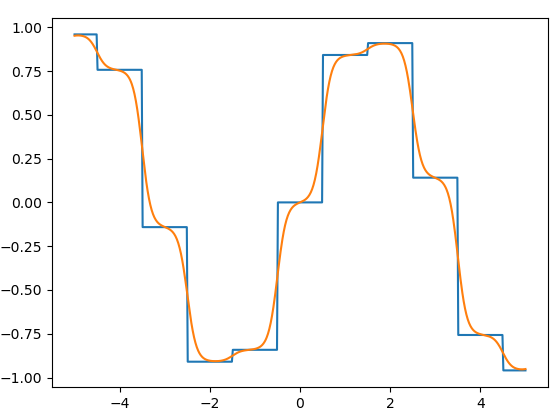

What is the "right" relaxation?

### An example compound histogram (some bins contain Formulas)

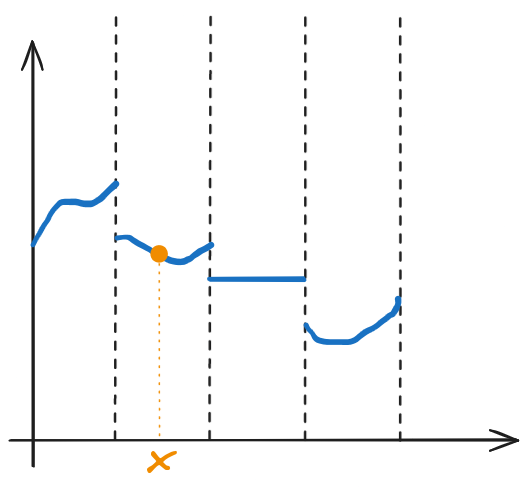

What is the "right" relaxation?

## Bonus: what about C++?

- autodifferentiable analyses are mostly a Python R&D topic, not a lot of interest in end-to-end differentiable analyses in C++ in the community
- via Python+JAX we can make fast progress, learn about the problem, the solution space, the technical hurdles, and then go for a C++ implementation in the future if needed
- at the time of writing I do not know of a C++ library that can autodifferentiate a compute graph evaluation the same way JAX does in this package (and implementing such a C++ library is a project of a larger scope than we feel like tackling at this point)
- I think the best option for C++ is implementing a code generator that produces code that evaluates a given correction, then pass the generated correction evaluation code through [enzyme](https://enzyme.mit.edu) or [clad](https://github.com/vgvassilev/clad)